In [1]:
import numpy as np
import hydra
import torch
from omegaconf import OmegaConf
from pytorch_lightning import (
    LightningDataModule,
    LightningModule,
    seed_everything,
)
from multimodal_contrastive.utils import utils
OmegaConf.register_new_resolver("sum", lambda input_list: np.sum(input_list))

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
device

'cpu'

In [3]:
# Load config for CLIP model
config_name = "puma_sg_clip"
configs_path = "../../configs"

with hydra.initialize(version_base=None, config_path=configs_path):
    cfg = hydra.compose(config_name=config_name)

cfg

{'datamodule': {'_target_': 'multimodal_contrastive.data.datamodule.MultiInput_DataModule', 'dataset': {'_target_': 'multimodal_contrastive.data.dataset.H5DatasetPUMA', 'data': '/home/mila/s/stephen.lu/gfn_gene/multimodal_contrastive/datasets/puma_by_mod_20240103.h5', 'labels': None, 'mods': ['struct', 'ge'], 'joint_as_input': False}, 'batch_size': 128, 'num_workers': 8, 'split_sizes': [0.8, 0.1, 0.1], 'split_type': 'scaffold'}, 'model': {'_target_': 'multimodal_contrastive.networks.models.CLIP_PL', 'loss_name': 'clip', 'temperature': 0.2, 'lr': 0.0001, 'dim': 128, 'ge_input_dim': 977, 'encode_dim': '${.dim}', 'proj_dim': '${.dim}', 'latent_dim': '${.dim}', 'hid_dim': '${.dim}', 'encoders_mod': {'struct': {'_target_': 'multimodal_contrastive.networks.components.GNEpropGIN', 'in_channels': 133, 'edge_dim': 12, 'hidden_channels': '${...encode_dim}', 'ffn_hidden_channels': None, 'num_layers': 5, 'out_channels': 1, 'num_readout_layers': 2, 'mol_features_size': 0.0, 'dropout': 0.0, 'jk': 'n

In [4]:
# set seed for random number generators in pytorch, numpy and python.random
# and especially for generating the same data splits for the test set
if cfg.get("seed"):
    seed_everything(cfg.seed, workers=True)

In [5]:
# Load test data split
datamodule: LightningDataModule = hydra.utils.instantiate(cfg.datamodule)
datamodule.setup("test")

train_loader = datamodule.train_dataloader()
test_loader = datamodule.test_dataloader()

/home/mila/s/stephen.lu/miniconda3/envs/mmc_sim/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


Train on samples from scaffold.
Train on 13582 samples.
Validate on 1698 samples.
Test on 1698 samples.


In [6]:
# Load model from checkpoint
ckpt_path = "../../runs/8wvlrmsr/checkpoints/epoch=9-step=1060.ckpt"
model: LightningModule = utils.instantiate_model(cfg)
model = model.load_from_checkpoint(ckpt_path, map_location=device)
model = model.eval()

INFO:root:Instantiating lightning model <multimodal_contrastive.networks.models.CLIP_PL>


In [8]:
# Set which loader to use
loader = test_loader

# Peek at the first example in the loaded set
example = next(iter(loader))
inputs = example["inputs"]
struct, ge = inputs["struct"], inputs["ge"]

print(struct)
print(ge.shape)

DataBatch(x=[3286, 133], edge_index=[2, 7148], edge_attr=[7148, 12], mols=[128], batch=[3286], ptr=[129])
torch.Size([128, 977])


In [9]:
# Get latent representations for all test examples
representations, mols = model.compute_representation_dataloader(
    loader,
    device=device,
    return_mol=True
)

100%|██████████| 13/13 [01:29<00:00,  6.90s/it]


In [10]:
# Save representations to disk
save = False
assert representations['struct'].shape[0] == len(mols)

if save:
    np.savez(
        "representations.npz",
        struct=representations['struct'],
        morph=representations['morph'],
        mols=mols
    )

In [13]:
# If dataset is too large, randomly subset to cutoff molecules
cutoff = 3000

if len(mols) > 3000:
    idx = np.random.choice(len(mols), cutoff, replace=False)
    pMols = np.array(mols)[idx]
    pRepresentations = {k: np.array(v)[idx] for k,v in representations.items()}
else:
    pMols = np.array(mols)
    pRepresentations = representations

In [14]:
# Use rdkit to get Morgan fingerprints for each molecule in mols
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

fpgen = AllChem.GetMorganGenerator(radius=3, fpSize=2048)

fps = []
for mol in tqdm(pMols):
    mol = Chem.MolFromSmiles(mol)
    fp = fpgen.GetSparseCountFingerprint(mol)
    fps.append(fp)

100%|██████████| 1664/1664 [00:01<00:00, 1625.43it/s]


In [26]:
# Compute pairwise similarities between all representations
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

cos_sim = cosine_similarity(pRepresentations['struct'])
eucl_dist = euclidean_distances(pRepresentations['struct'])

In [22]:
# Compute tanimoto and dice similarity between all fingerprints
num_mols = len(fps)
tanimoto_sim = np.zeros((num_mols, num_mols))
dice_sim = np.zeros((num_mols, num_mols))

for i in tqdm(range(num_mols)):
    for j in range(i, num_mols):
        tanimoto_sim[i, j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])
        dice_sim[i, j] = DataStructs.DiceSimilarity(fps[i], fps[j])

100%|██████████| 1664/1664 [00:17<00:00, 94.52it/s] 


In [27]:
cos_sim.shape, eucl_dist.shape, tanimoto_sim.shape

((1664, 1664), (1664, 1664), (1664, 1664))

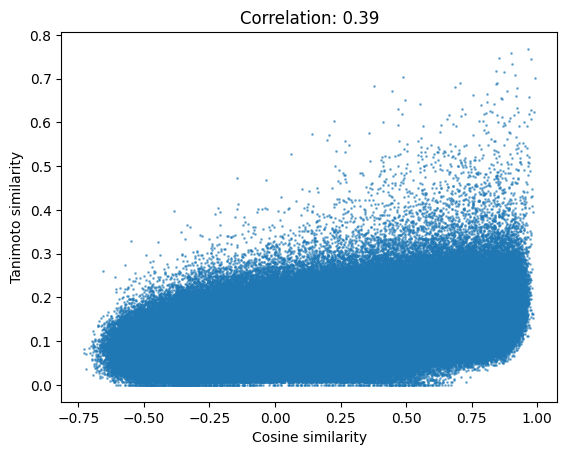

In [28]:
# Plot correlation between tanimoto similarity and cosine similarity
import matplotlib.pyplot as plt

# Only use upper triangle of matrix since both metrics are symmetric
cos_sim_half = cos_sim[np.triu_indices(num_mols, k=1)]
tanimoto_sim_half = tanimoto_sim[np.triu_indices(num_mols, k=1)]

# Compute correlation between the two metrics
correlation = np.corrcoef(cos_sim_half, tanimoto_sim_half)

plt.scatter(cos_sim_half, tanimoto_sim_half, alpha=0.5, s=1)
plt.xlabel("Cosine similarity")
plt.ylabel("Tanimoto similarity")
plt.title(f"Correlation: {correlation[0, 1]:.2f}")
plt.show()

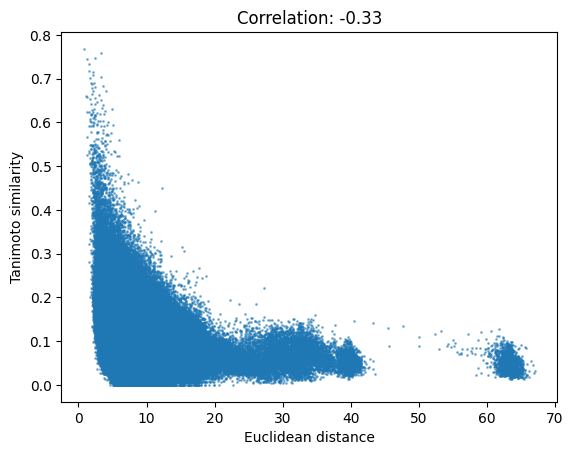

In [29]:
# Plot correlation between tanimoto similarity and euclidean similarity
import matplotlib.pyplot as plt

# Only use upper triangle of matrix since both metrics are symmetric
eucl_dist_half = eucl_dist[np.triu_indices(num_mols, k=1)]
tanimoto_sim_half = tanimoto_sim[np.triu_indices(num_mols, k=1)]

# Compute correlation between the two metrics
correlation = np.corrcoef(eucl_dist_half, tanimoto_sim_half)

plt.scatter(eucl_dist_half, tanimoto_sim_half, alpha=0.5, s=1)
plt.xlabel("Euclidean distance")
plt.ylabel("Tanimoto similarity")
plt.title(f"Correlation: {correlation[0, 1]:.2f}")
plt.show()